<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/316_conjugate_families.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(sec-distr-coniugate)=
# Distribuzioni coniugate

L'obiettivo principale di questo capitolo è fornire un esempio dettagliato di come derivare la distribuzione a posteriori scegliendo una distribuzione a priori coniugata. In particolare, esploreremo un modello noto come schema beta-binomiale. Questo esempio illustrerà come le distribuzioni a priori coniugate possono semplificare il processo di inferenza bayesiana, consentendo di ottenere una distribuzione a posteriori in modo analitico.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats
from scipy import integrate
import numpy as np
import pymc as pm
from scipy.stats import beta

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Derivazione analitica della distribuzione a posteriori

Le distribuzioni a priori coniugate costituiscono una classe speciale di distribuzioni di probabilità con una caratteristica significativa: se la distribuzione a priori appartiene a questa classe, anche la distribuzione a posteriori appartiene alla stessa categoria e mantiene la stessa forma funzionale. Questo aspetto semplifica notevolmente l'aggiornamento delle nostre credenze riguardo al parametro di interesse, in quanto coinvolge semplicemente la modifica dei parametri della distribuzione a priori. Ad esempio, quando selezioniamo una distribuzione a priori Beta e la verosimiglianza corrisponde a una distribuzione binomiale, la distribuzione a posteriori sarà anch'essa una distribuzione Beta.

Nonostante le distribuzioni a priori coniugate siano l'opzione preferibile dal punto di vista matematico, poiché consentono di calcolare in modo analitico la distribuzione a posteriori evitando calcoli complessi, le moderne tecniche di inferenza bayesiana offrono la flessibilità di utilizzare una vasta gamma di distribuzioni a priori, senza dover limitare la scelta alle distribuzioni coniugate. Tuttavia, è importante sottolineare che le distribuzioni a priori coniugate continuano a svolgere un ruolo importante nell'insegnamento dell'inferenza bayesiana. In questo capitolo, esploreremo in dettaglio il modello beta-binomiale, un caso in cui l'accoppiamento della distribuzione a priori Beta con la verosimiglianza binomiale gioca un ruolo centrale nell'inferenza sulla proporzione.

## Lo schema beta-binomiale 

La distribuzione Beta è una funzione di probabilità che trova applicazione nella descrizione della variabilità di una variabile casuale limitata all'intervallo [0,1]. I suoi parametri, indicati come $\alpha$ e $\beta$, determinano la sua forma. Questa distribuzione è particolarmente indicata per rappresentare le nostre convinzioni iniziali riguardo a una proporzione.

Una volta raccolti i dati e ottenuto un valore osservato per la proporzione, possiamo sfruttare l'approccio bayesiano per ottenere la distribuzione a posteriori. Questo processo comporta la combinazione della distribuzione a priori con la verosimiglianza, consentendoci di raffinare le nostre credenze sulla proporzione. Per maggiori dettagli sulla distribuzione Beta, si può fare riferimento al capitolo {ref}`cont-rv-distr-notebook`.

Se scegliamo la distribuzione Beta, la distribuzione a priori è

$$
\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}.
$$

Omettiamo qui il fattore di normalizzazione di cui non c'è bisogno perché la normalizzazione verrà eseguita dopo l'aggiornamento bayesiano.

Per una proporzione, la verosimiglianza è data dalla distribuzione Binomiale:

$$
\theta^{y} (1 - \theta)^{n - y}.
$$

Nuovamente, omettiamo il fattore di normalizzazione.

Per calcolare la distribuzione a posteriori, dobbiamo moltiplica la funzione nucleo a priori Beta per la funzione nucleo della verosimiglianza Binomiale:

$$
\theta^{\alpha - 1} (1 - \theta)^{\beta - 1} \cdot \theta^{y} (1 - \theta)^{n - y} = \theta^{\alpha - 1 + y} (1 - \theta)^{\beta - 1 + n - y}.
$$

La formula risultante rappresenta la distribuzione Beta non normalizzata con i parametri $\alpha+y$ e $\beta+n-y$. In altre parole, se osserviamo $y$ successi in $n$ prove Bernoulliane e scegliamo una distribuzione a priori Beta con i parametri $\alpha$ e $\beta$, il processo di aggiornamento bayesiano produce una distribuzione a posteriori Beta di parametri $\alpha+y$ e $\beta+n-y$.

L'esempio appena descritto rappresenta un caso di analisi coniugata. In particolare, la combinazione della funzione di verosimiglianza Binomiale e della distribuzione a priori Beta è nota come il caso coniugato "beta-binomiale", ed è regolato dal seguente teorema.

```{admonition} Teorema
Supponiamo di avere una funzione di verosimiglianza $Bin(n, y \mid \theta)$ e una distribuzione a priori $Beta(\alpha, \beta)$. In questo caso, la distribuzione a posteriori del parametro $\theta$ sarà una distribuzione $Beta(\alpha + y, \beta + n - y)$. 
```

### AIDS

Per esemplificare in maniera concreta il concetto della distribuzione coniugata beta-binomiale, esaminiamo i dati provenienti dall'Australian National Centre in HIV Epidemiology and Clinical Research, inclusi nel pacchetto R chiamato MASS. All'interno del DataFrame denominato "Aids2" sono raccolte informazioni riguardanti gli individui che sono stati diagnosticati con l'AIDS prima del primo luglio 1991. Complessivamente, sono stati registrati 2843 casi, tra cui, fino a quella data, 1082 erano ancora in vita mentre 1761 erano deceduti. Il nostro interrogativo verte sul tasso di mortalità.

Se trattiamo i casi come eventi indipendenti, i dati osservati ($y = 1082$) possono essere interpretati come una sequenza di variabili casuali di tipo Bernoulliano, dunque la verosimiglianza assume una distribuzione binomiale. Nel caso in cui optiamo per una distribuzione a priori debolmente informativa di tipo Beta, con parametri $\alpha = 2$ e $\beta = 2$, la distribuzione a posteriori si presenterà come una distribuzione Beta con parametri $2 + 1761$ e $2 + 2843 - 1761$, ovvero Beta(1763, 1084).

In [3]:
def plot_beta(alpha, beta, mean=False, mode=False, color="k"):
    theta = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(theta, alpha, beta)
    plt.plot(theta, p_theta_given_y, lw=2, color=color)
    
    if mean:
        mean_value = alpha / (alpha + beta)
        mean_value = min(max(mean_value, 0), 1)  # Ensure mean_value is within [0, 1]
        plt.axvline(mean_value, linestyle='dashed', color=color)
    
    plt.xlabel("$\\theta$")
    plt.ylabel("$f(\\theta)$")
    
    # Set lower y-limit to 0
    plt.ylim(bottom=0)

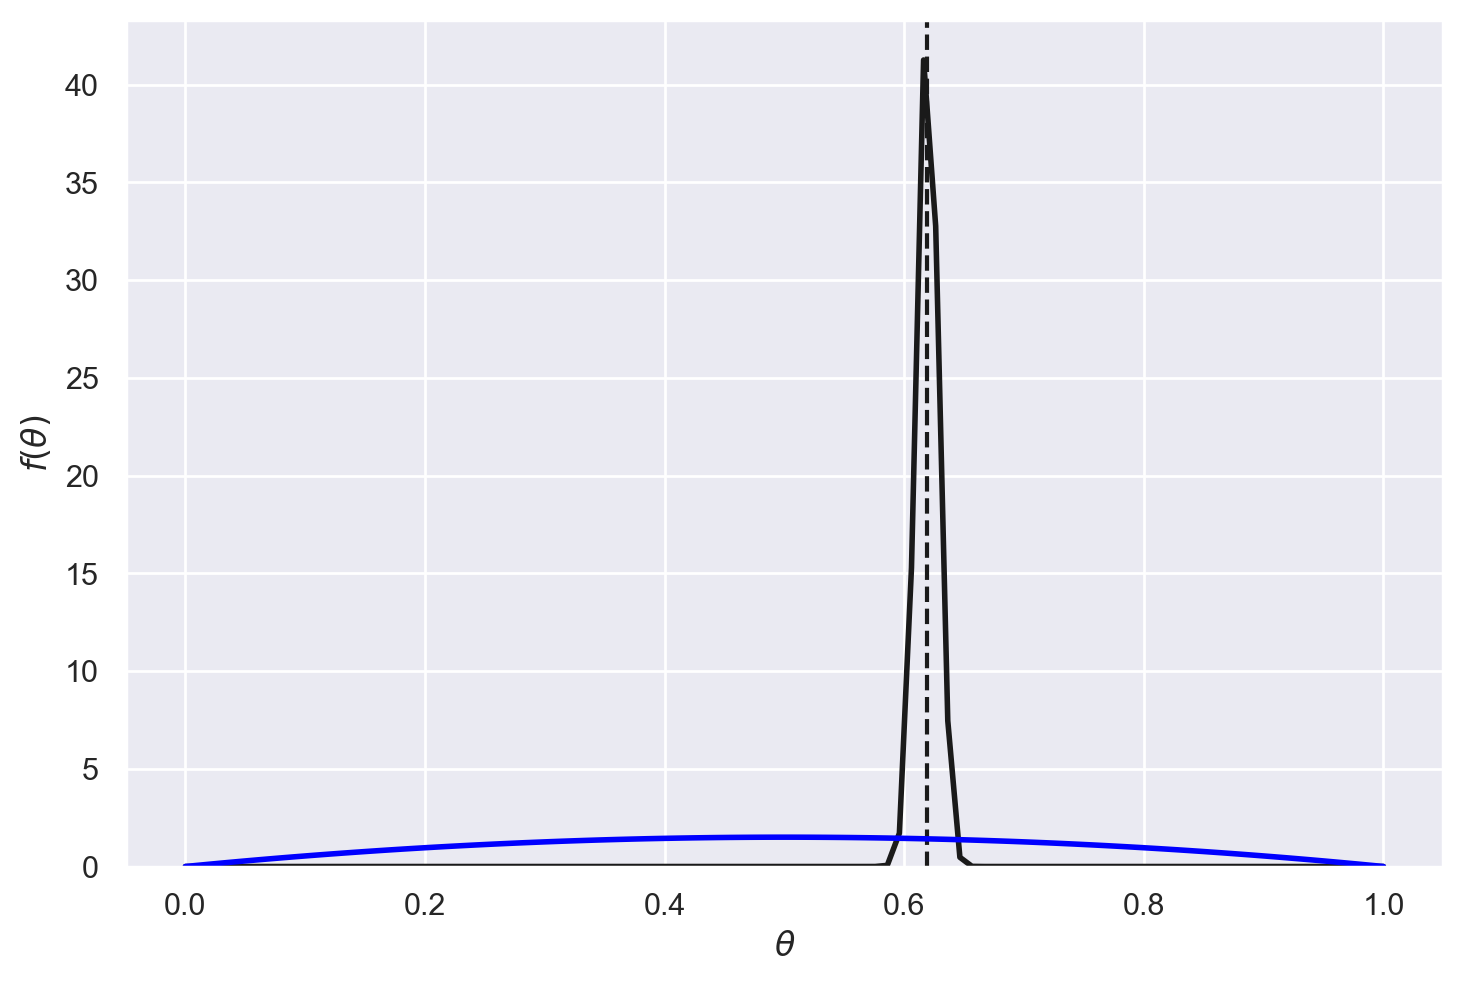

In [4]:

plot_beta(alpha=1763, beta=1084, mean=True)
plot_beta(alpha=2, beta=2, color="blue")

### La distribuzione a priori

La distribuzione Beta ci consente di esprimere le nostre credenze iniziali riguardo a $\theta$, che rappresenta la probabilità di avere un'aspettativa distorta negativamente. Ad esempio, scegliendo una distribuzione a priori $Beta(\alpha = 2, \beta = 2)$ per il parametro $\theta$, esprimiamo la nostra convinzione iniziale che, nel 1991, ci sia una considerevole incertezza riguardo all'evento "sopravvivere dopo la diagnosi dell'AIDS". In particolare, il valore 0.5 è considerato il valore di $\theta$ più plausibile, ma anche gli altri valori del parametro (esclusi gli estremi) sono ritenuti abbastanza plausibili. 

Un sommario della distribuzione $Beta(alpha=2, beta=2)$ si ottiene usando la funzione seguente:

In [5]:
def summarize_beta(alpha, beta):
    """Summarize a Beta Model for \eqn{\pi}

    @param alpha,beta positive shape parameters of the Beta model

    Return Pandas Series with summary
    """

    mean = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    sd = np.sqrt(var)

    if alpha < 1 and beta < 1:
        mode = "0 and 1"
    elif alpha <= 1 and beta > 1:
        mode = 0
    elif alpha > 1 and beta < 1:
        mode = 1
    else:
        mode = (alpha - 1) / (alpha + beta - 2)
    return pd.Series({"mean": mean, "mode": mode, "var": var, "sd": sd})

In [21]:
summarize_beta(alpha=2, beta=2)

mean    0.500000
mode    0.500000
var     0.050000
sd      0.223607
dtype: float64

Possiamo quantificare la nostra incertezza calcolando, con un grado di fiducia del 94%, la regione nella quale, in base a tale credenza a priori, si trova il valore del parametro. Per ottenere tale intervallo di credibilità a priori, usiamo la funzione `beta.ppf` di `scipy.stats`. 

In [6]:
li = beta.ppf(0.03, 2, 2)
ls = beta.ppf(0.97, 2, 2)
list([li, ls])

[0.10364483924951279, 0.8963551607504872]

Se poniamo $\alpha=10$ e $\beta=10$, anche questa scelta descrive una credenza a priori per la quale il valore più credibile per $\theta$ è 0.5.

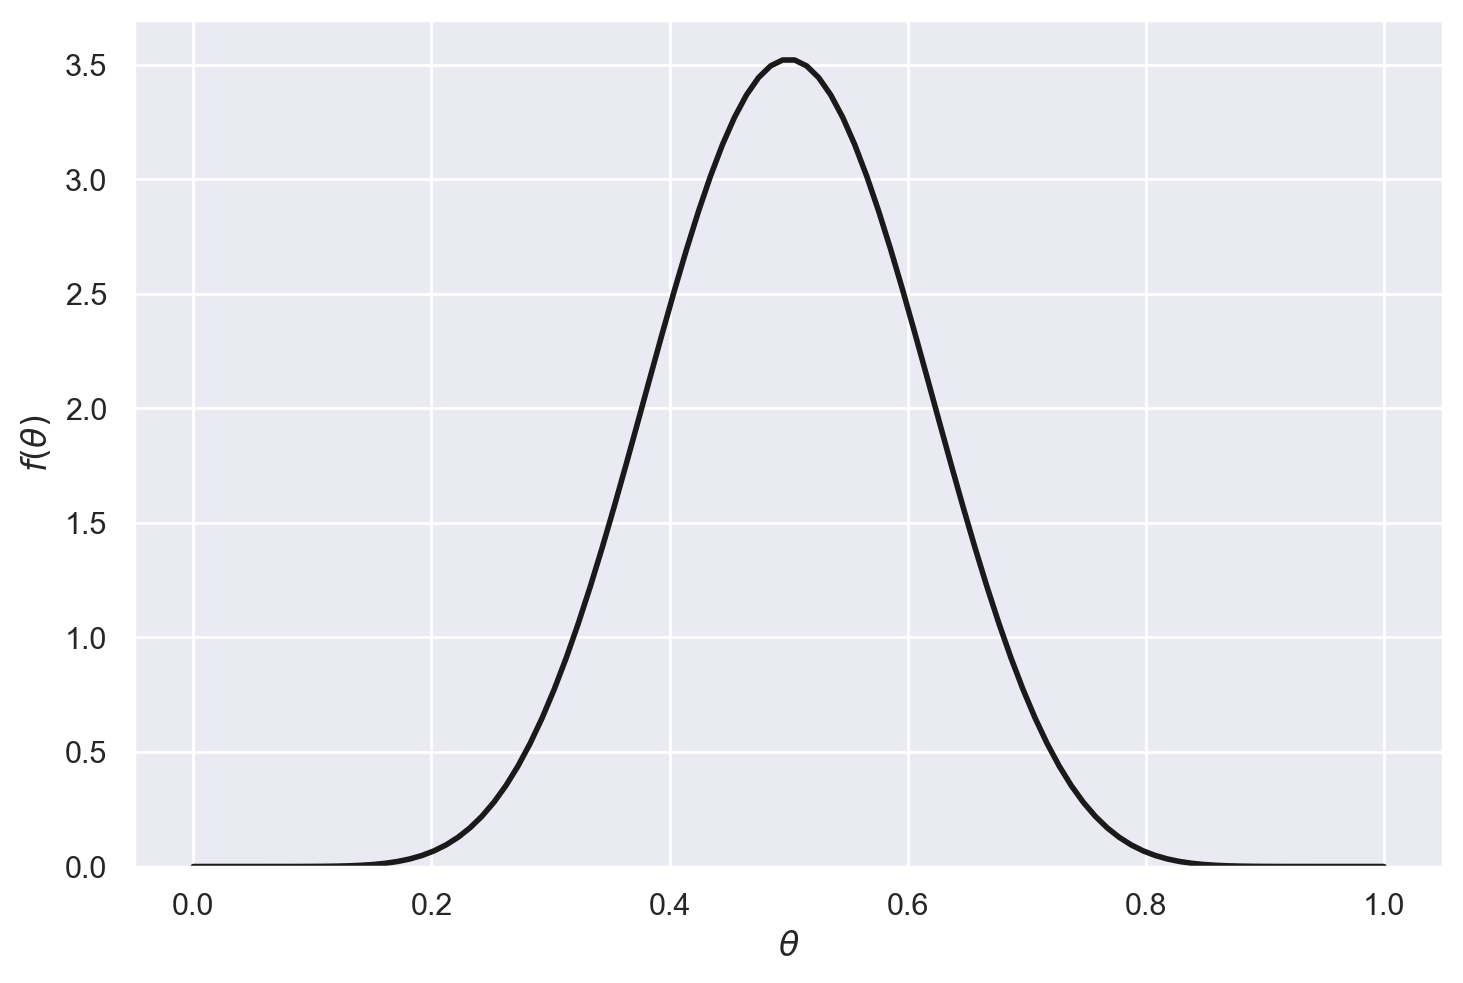

In [7]:
plot_beta(10, 10)

Tuttavia, in questo caso la nostra certezza a priori sul valore del parametro è maggiore, come indicato dall'intervallo di ordine 0.95.

In [8]:
li = beta.ppf(0.03, 10, 10)
ls = beta.ppf(0.97, 10, 10)
list([li, ls])

[0.2964110284916252, 0.7035889715083747]

Quale distribuzione a priori dobbiamo scegliere? In un problema concreto di analisi dei dati, la scelta della distribuzione a priori dipende dalle credenze a priori che vogliamo includere nell'analisi dei dati. Se non abbiamo alcuna informazione a priori, allora è possibile usare $\alpha=1$ e $\beta=1$, che corrisponde ad una distribuzione a priori uniforme. Ma l'uso di distribuzioni a priori uniformi è sconsigliato per vari motivi, inclusa l'instabilità numerica della stima dei parametri. In tali circostanze sarebbe preferibile usare una distribuzione a priori debolmente informativa, come una $Beta(2, 2)$.

### La distribuzione a posteriori

Una volta scelta una distribuzione a priori $Beta(2, 2)$, i cui parametri rispecchiano le nostre credenze iniziali su $\theta$, la distribuzione a posteriori diventa una Beta di parametri $\alpha + y$ e $\beta + n - y$. Per i dati dell'esempio, otteniamo la distribuzione a posteriori $p(\theta \mid n, y) \sim Beta(1763, 1084)$.

Essendo $\mathbb{E}[Beta(\alpha, \beta)] = \frac{\alpha}{\alpha + \beta}$, il valore atteso a posteriori di $\theta$ può essere calcolato come:

$$
\mathbb{E}_{\text{post}} [\mathrm{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta +n}.
$$ (eq-ev-post-beta-bin-1)

Rappresentiamo qui sotto graficamente l'aggiornamento bayesiano beta-binomiale per i dati in esame nel caso di una distribuzione a priori $Beta(2, 2)$.

In [9]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(
        θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2
    )
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ,
        likelihood / scale_factor,
        lw=4,
        color="b",
        label="likelihood scaled",
        alpha=0.2,
    )
    plt.xlabel(r"$\theta$")
    plt.ylabel("density")
    plt.legend()


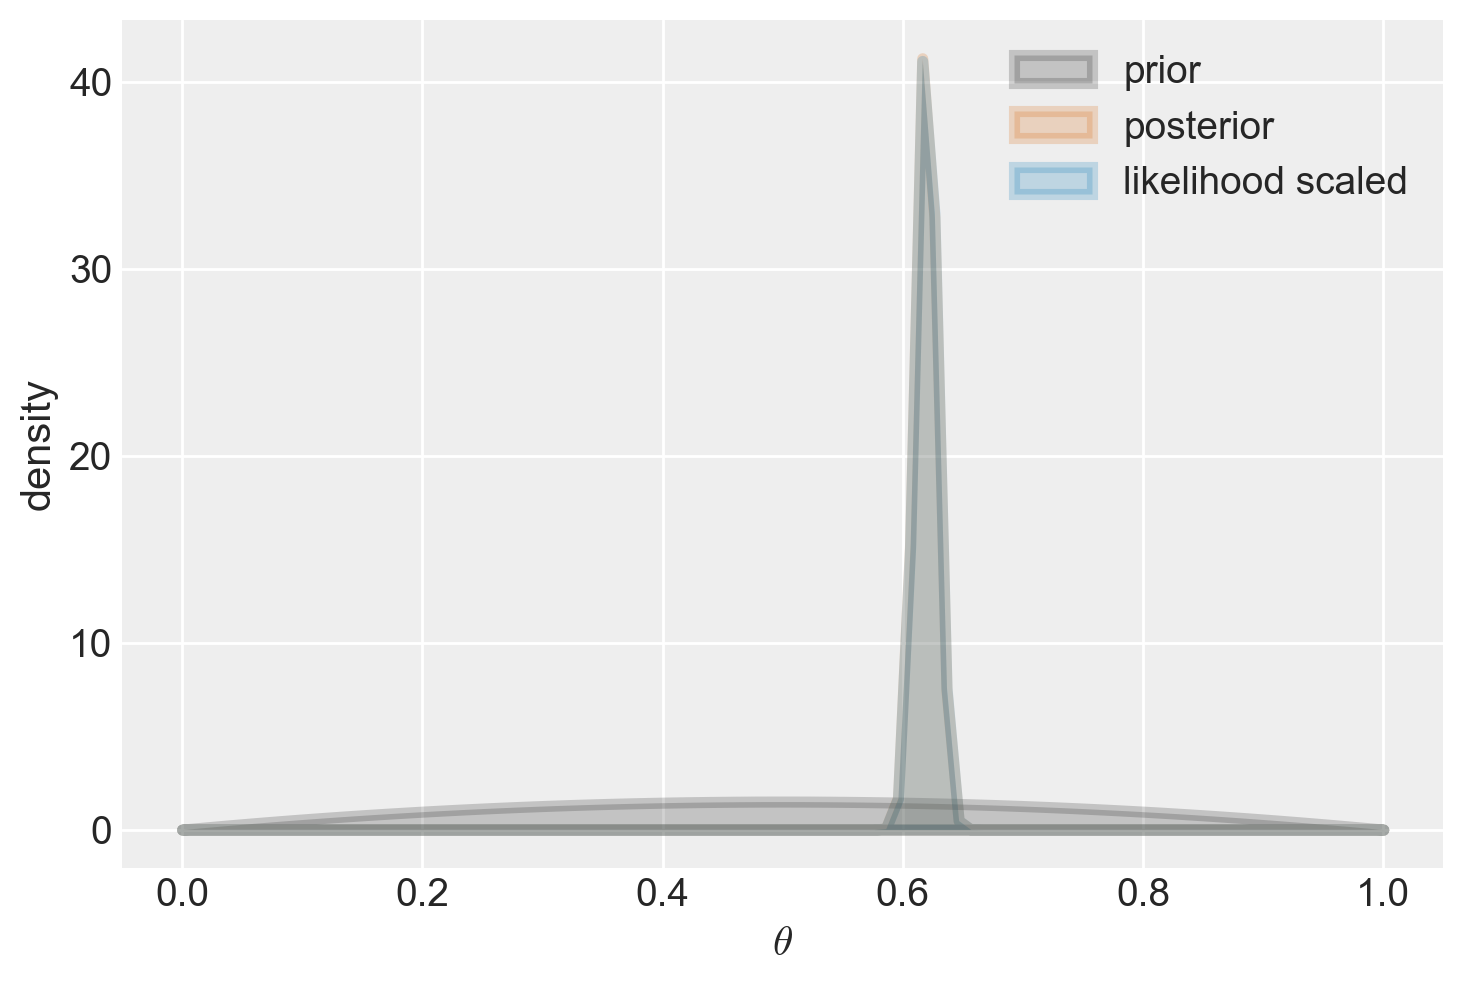

In [26]:
plot_beta_binomial(alpha=2, beta=2, y=1761, n=2843)

In questo caso, la distribuzione a priori è debolmente informativa, la verosimiglianza è molto forte, per cui la distribuzione a posteriori è praticamente sovrapposta alla verosimiglianza (normalizzata).

In [10]:
summarize_beta(1763, 1084)

mean    0.619248
mode    0.619332
var     0.000083
sd      0.009099
dtype: float64

In [11]:
li = beta.ppf(0.03, 1763, 1084)
ls = beta.ppf(0.97, 1763, 1084)
list([li, ls])

[0.6020654882558294, 0.6362894604661353]

Utilizzando il metodo della massima verosimiglianza, il tasso di mortalità stimato è $\theta = 1761/2843 = 0.62$, con un errore standard (SE) di $\sqrt{0.62(1−0.62)/n} = 0.0091$ e un intervallo di confidenza al 95% di [0.6, 0.63], che è simile all'intervallo ottenuto con l'inferenza bayesiana.

In [14]:
[.62 - stats.norm.ppf(0.97) * 0.0091, .62 + stats.norm.ppf(0.97) * 0.0091]

[0.6028847781658236, 0.6371152218341763]

Se analizziamo l'influenza della scelta di diverse distribuzioni a priori sulla distribuzione a posteriori, possiamo notare che è necessario avere una distribuzione a priori molto forte affinché essa abbia un effetto sostanziale. Inoltre, per ottenere conclusioni sostanzialmente diverse, la distribuzione a priori e i dati devono essere in disaccordo.

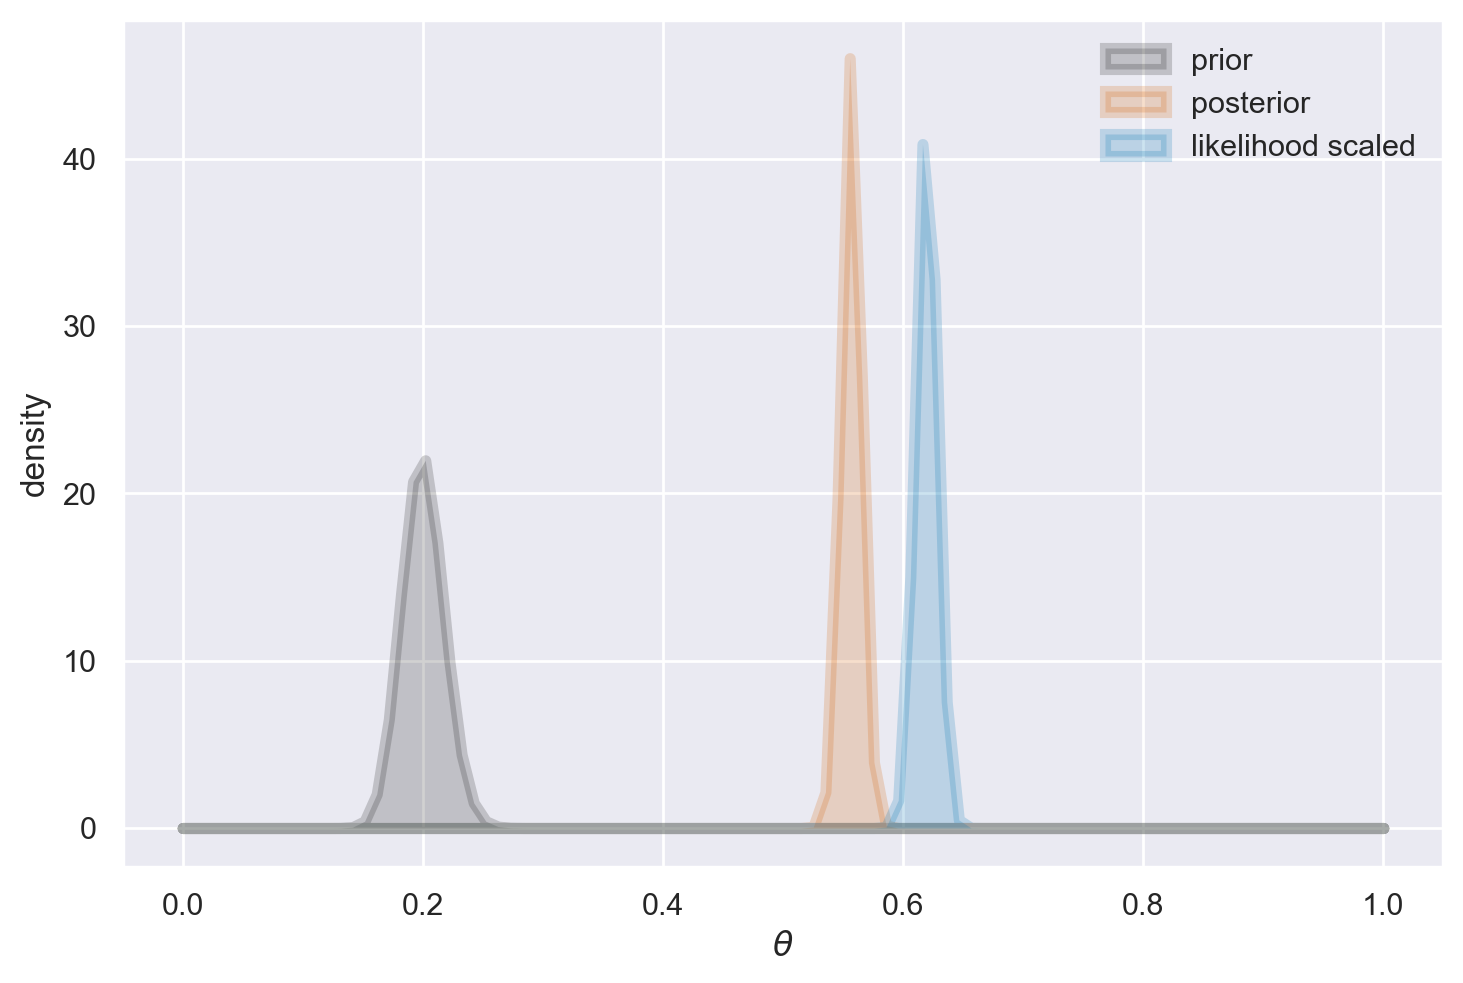

In [15]:
plot_beta_binomial(alpha=100, beta=400, y=1761, n=2843)

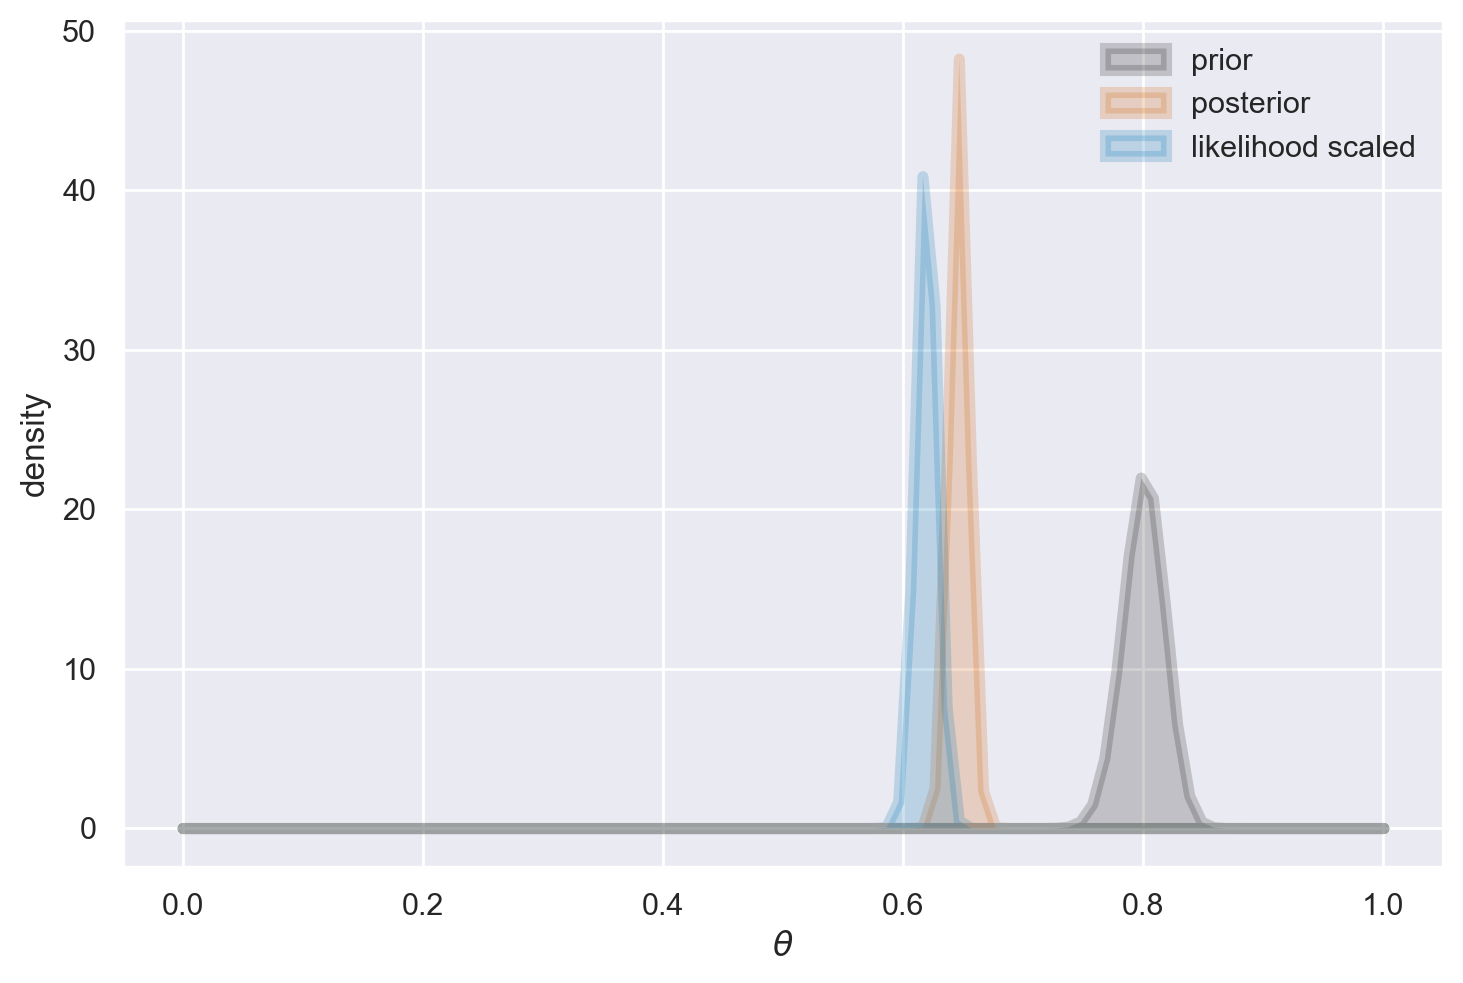

In [16]:
plot_beta_binomial(alpha=400, beta=100, y=1761, n=2843)

### La ricerca sull'obbedienza di Milgram

Consideriamo un altro esempio relativo alla ricerca di Stanley Milgram discussa da {cite:t}`Johnson2022bayesrules`. Nel 1963, Stanley Milgram presentò una ricerca sulla propensione delle persone a obbedire agli ordini di figure di autorità, anche quando tali ordini possono danneggiare altre persone {cite:t}`milgram1963behavioral`. Nell'articolo, Milgram descrive lo studio come

> consist\[ing\] of ordering a naive subject to administer electric shock to a victim. A simulated shock generator is used, with 30 clearly marked voltage levels that range from IS to 450 volts. The instrument bears verbal designations that range from Slight Shock to Danger: Severe Shock. The responses of the victim, who is a trained confederate of the experimenter, are standardized. The orders to administer shocks are given to the naive subject in the context of a "learning experiment" ostensibly set up to study the effects of punishment on memory. As the experiment proceeds the naive subject is commanded to administer increasingly more intense shocks to the victim, even to the point of reaching the level marked Danger: Severe Shock.

All'insaputa del partecipante, gli shock elettrici erano falsi e l'attore stava solo fingendo di provare il dolore dello shock.

{cite:t}`Johnson2022bayesrules` fanno inferenza sui risultati dello studio di Milgram mediante il modello Beta-Binomiale. Il parametro di interesse è la probabilità $\theta$ che una persona obbedisca all'autorità, anche se ciò comporta il rischio di recare danno ad altri, in questo caso somministrando lo shock più severo. Gli autori ipotizzano che, prima di raccogliere dati, le credenze di Milgram riguardo a $\theta$ possano essere rappresentate mediante una distribuzione Beta con parametri $\alpha=1$ e $\beta=10$.

Sia $y = 26$ il numero di soggetti, su un totale di 40 partecipanti, che hanno accettato di infliggere lo shock più severo. Poiché si assume che ciascun partecipante si comporti in modo indipendente dagli altri, la dipendenza di $y$ da $\theta$ può essere modellata mediante la distribuzione binomiale. Di conseguenza, si giunge al seguente modello bayesiano Beta-Binomiale:

$$
\begin{align}
y \mid \theta & \sim \text{Bin}(n = 40, \theta) \notag\\
\theta & \sim \text{Beta}(1, 10) \; . \notag
\end{align}
$$

Il processo di aggiornamento bayesiano è descritto dalla figura ottenuta con la funzione `plot_beta_binomial()`.

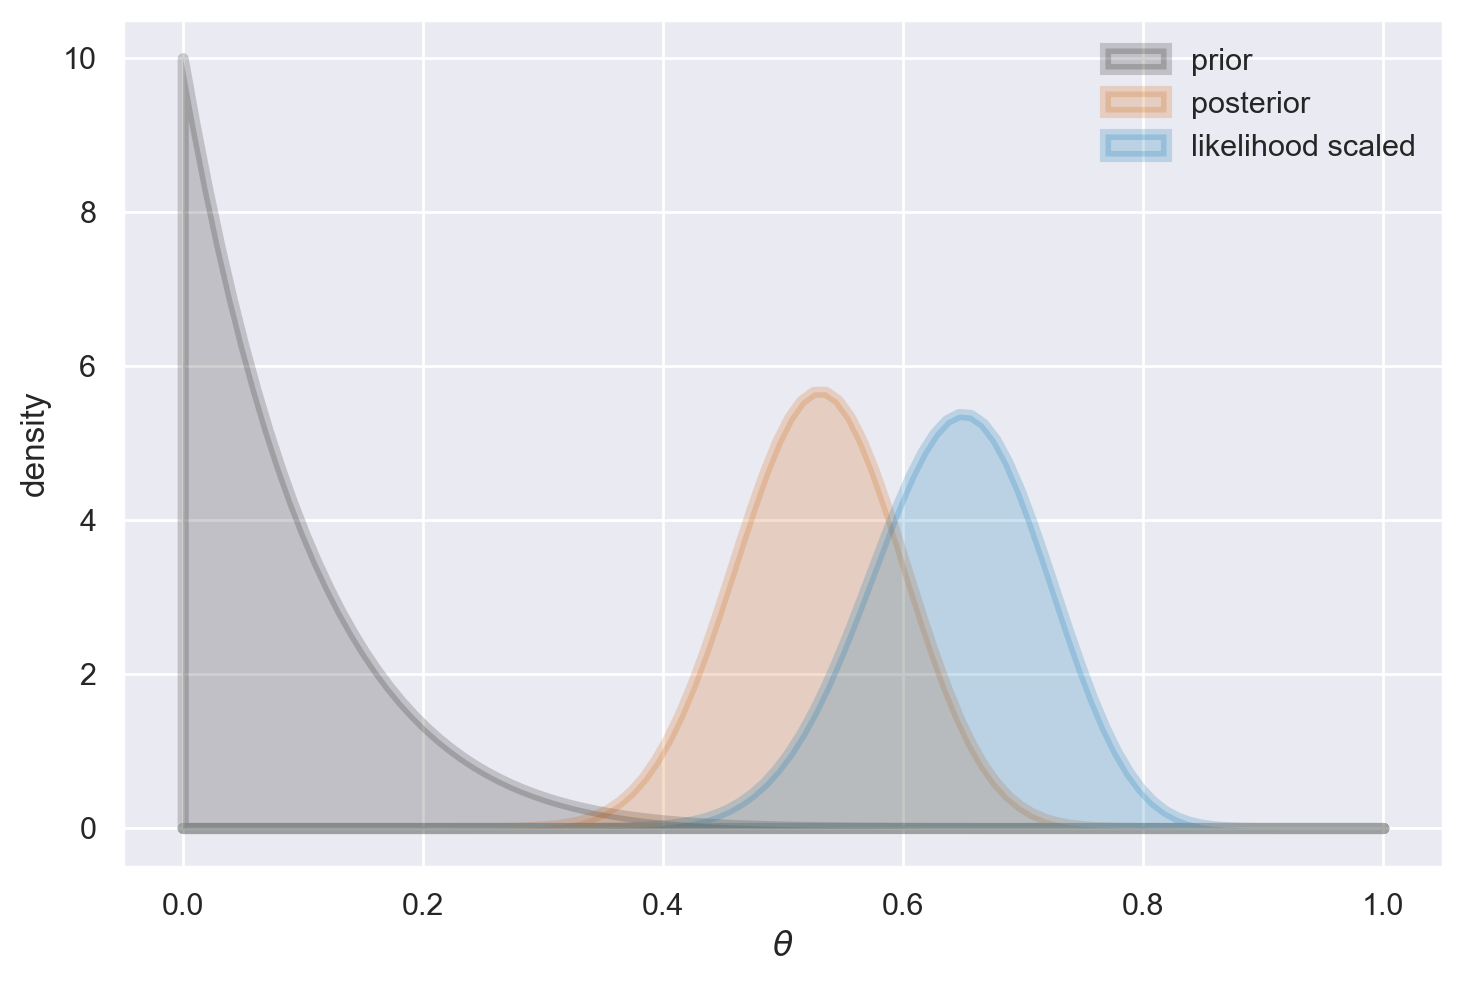

In [17]:
plot_beta_binomial(alpha=1, beta=10, y=26, n=40)

## Inferenza bayesiana 

L'inferenza bayesiana sulla proporzione $\theta$ si basa su diversi riepiloghi della distribuzione a posteriori Beta. Il tipo di riepilogo che si calcola dalla distribuzione a posteriori dipende dal tipo di inferenza che si vuole effettuare. In generale, possiamo distinguere due tipi di inferenza.

Il primo tipo (verifica di ipotesi bayesiana) riguarda problemi in cui siamo interessati a valutare la plausibilità che il parametro $\theta$ assuma valori contenuti in un dato intervallo di valori. In questo caso, possiamo calcolare la probabilità a posteriori che $\theta$ cada nell'intervallo di interesse, integrando la distribuzione a posteriori Beta su tale intervallo.

Il secondo tipo di inferenza (intervalli di credibilità) riguarda invece la stima dell'intervallo che contiene il parametro $\theta$ ad un dato livello di probabilità soggettiva. In questo caso, possiamo utilizzare i quantili della distribuzione a posteriori Beta per calcolare l'intervallo di probabilità richiesto. Ad esempio, per stimare l'intervallo che contiene il 95% della massa a posteriori, possiamo calcolare i quantili corrispondenti alla probabilità cumulativa 0.025 e 0.975 della distribuzione a posteriori.

### Verifica di ipotesi bayesiana

Nell'esempio relativo di dati di Milgram, la nostra credenza a posteriori relativa al parametro $\theta$ (ovvero, la probabilità di obbedire all'autorità) è descritta dalla distribuzione Beta(27, 24). Una volta definita la distribuzione a posteriori, possiamo porci ulteriori domande. Ad esempio, potremmo chiederci: qual è la probabilità che il valore di $\theta$ sia maggiore di 0.5?

Per rispondere a questa domanda, possiamo utilizzare la distribuzione a posteriori Beta(27, 24) e calcolare la probabilità che $\theta$ sia maggiore di 0.5 integrando la distribuzione a posteriori da 0.5 a 1. Possiamo esprimere questo calcolo come segue:

$$
P(\theta > 0.5) = 1 - \int_0^{0.5} Beta(\alpha + y, \beta + n - y) d \theta.
$$


In [14]:
1 - stats.beta.cdf(0.5, 27, 24)

0.6640944831173172

### Intervalli di credibilità

Un secondo tipo di inferenza bayesiana è quella che ci porta a costruire gli intervalli di credibilità. Un intervallo di credibilità di ordine $a \in [0, 1]$ è l'intervallo di valori che contiene una proporzione della distribuzione a posteriori pari ad $a$. 

Dato che conosciamo la funzione a posteriori, possiamo semplicemente calcolare i quantili, al livello di probabilità desiderato, per calcolare l'intervallo di credibilità che lascia la stessa probabilità nelle due code.

In [18]:
li = stats.beta.ppf(0.03, 27, 24)
ls = stats.beta.ppf(0.97, 27, 24)
list([li, ls])


[0.3986201110959706, 0.6582462555099745]

In alternativa, possiamo calcolare la regione con la più alta densità a posteriori, ovvero la regione (non è necessariamente un intervallo) più corta che contiene la frazione $1 − \alpha$ della densità.

Questo risultato può essere trovato usando la funzione `hdi` del modulo `arviz`. Come input della funzione dobbiamo fornire un campione di valori dalla distribuzione a posteriori.

In [19]:
nsim = 1000000
theta_samples = np.random.beta(27, 24, size=nsim)
az.hdi(theta_samples, hdi_prob=0.94)


array([0.39842633, 0.65796317])

Nel caso presente, l'intervallo di credibilità che lascia la stessa probabilità nelle due code e le regioni HPD sono quasi identici.

Abbiamo anche introdotto il concetto di intervallo di confidenza frequentista, che viene calcolato come

$$
\text{stima del parametro} \pm t \cdot \text{errore standard},
$$

dove $t$ rappresenta il quantile della distribuzione $t$ di Student, corrispondente al valore che lascia sotto di sé la probabilità pari a $1 - \alpha/2$.

## Principali distribuzioni coniugate

Esistono altre combinazioni di verosimiglianza e distribuzione a priori che producono una distribuzione a posteriori con la stessa forma della distribuzione a priori. Ecco alcune delle più note coniugazioni tra modelli statistici e distribuzioni a priori:

- Nel modello Normale-Normale $\mathcal{N}(\mu, \sigma^2_0)$, la distribuzione a priori è $\mathcal{N}(\mu_0, \tau^2)$ e la distribuzione a posteriori è $\mathcal{N}\left(\frac{\mu_0\sigma^2 + \bar{y}n\tau^2}{\sigma^2 + n\tau^2}, \frac{\sigma^2\tau^2}{\sigma^2 + n\tau^2} \right)$.

- Nel modello Poisson-gamma $\text{Po}(\theta)$, la distribuzione a priori è $\Gamma(\lambda, \delta)$ e la distribuzione a posteriori è $\Gamma(\lambda + n \bar{y}, \delta +n)$.

- Nel modello esponenziale $\text{Exp}(\theta)$, la distribuzione a priori è $\Gamma(\lambda, \delta)$ e la distribuzione a posteriori è $\Gamma(\lambda + n, \delta +n\bar{y})$.

- Nel modello uniforme-Pareto $\text{U}(0, \theta)$, la distribuzione a priori è $\text{Pa}(\alpha, \varepsilon)$ e la distribuzione a posteriori è $\text{Pa}(\alpha + n, \max(y_{(n)}, \varepsilon))$.

## Critiche dei modelli con famiglie coniugate

Prima di concludere il capitolo, è importante riconoscere che i modelli basati sul concetto di famiglie coniugate presentano anche delle limitazioni. In particolare, un modello con una distribuzione a priori coniugata potrebbe non essere sempre sufficientemente flessibile per adattarsi alle nostre credenze iniziali (prima di avere osservato i dati). Ad esempio, un modello normale è sempre unimodale e simmetrico rispetto alla media $\mu$. Tuttavia, se la nostra comprensione preliminare non è simmetrica o non è unimodale, la distribuzione a priori normale potrebbe non essere la scelta più appropriata [@Johnson2022bayesrules].

## Commenti e considerazioni finali 

Nel capitolo, abbiamo appreso come unire le conoscenze a priori e le evidenze dai dati per ottenere una stima della distribuzione di probabilità a posteriori del parametro $\theta$, che rappresenta l'incertezza su un parametro di interesse. Quando $\theta$ rappresenta la probabilità di successo in una sequenza di prove Bernoulliane, abbiamo utilizzato una distribuzione a priori Beta per esprimere le nostre credenze iniziali su $\theta$. Grazie alla funzione di verosimiglianza binomiale, abbiamo potuto applicare il teorema di Bayes e ottenere la distribuzione a posteriori, anch'essa una distribuzione Beta. Questo metodo di inferenza statistica è noto come schema "beta-binomiale" e ci permette di calcolare analiticamente i parametri della distribuzione a posteriori utilizzando una distribuzione a priori coniugata. In questo modo, otteniamo una stima più precisa dell'incertezza sul parametro $\theta$, basata sia sulle nostre conoscenze a priori che sui dati osservati.

## Watermark

In [17]:
%watermark -n -u -v -iv

Last updated: Fri May 05 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.1

numpy     : 1.23.5
pymc      : 5.3.0
seaborn   : 0.12.2
arviz     : 0.15.1
scipy     : 1.10.1
pandas    : 2.0.1
matplotlib: 3.7.1

